In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)

df = pd.read_csv('blogs.csv')
df.columns = ['Text', 'Category']

/tmp/ipykernel_12386/3240749300.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Category'], order=df['Category'].value_counts().index, palette='viridis')


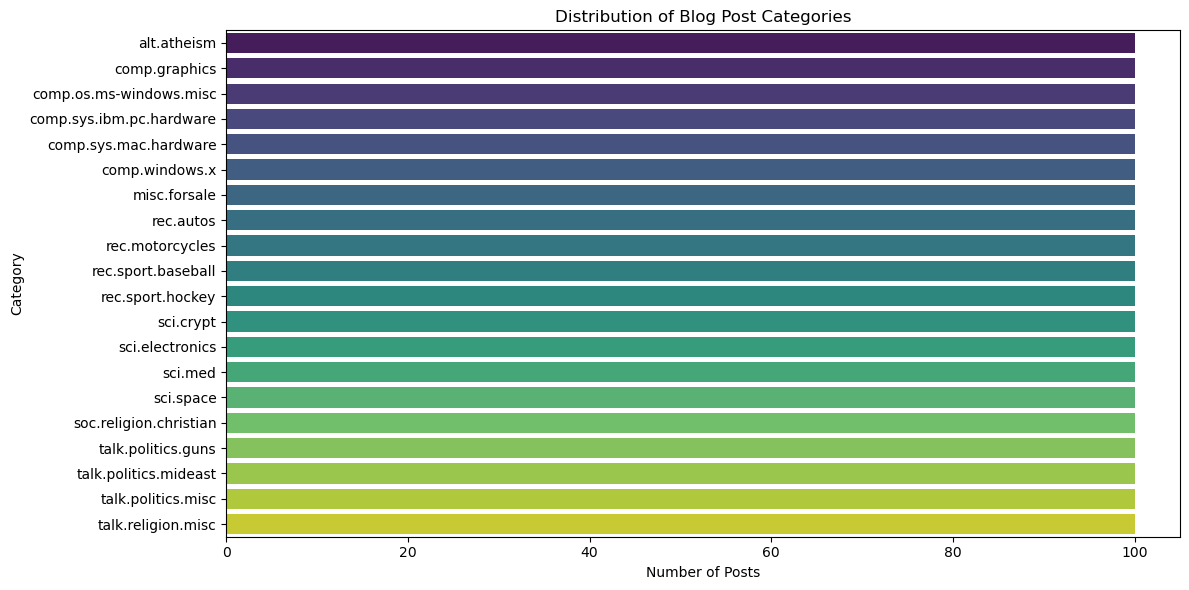

In [2]:
# Category Distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Category'], order=df['Category'].value_counts().index, palette='viridis')
plt.title('Distribution of Blog Post Categories')
plt.xlabel('Number of Posts')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

In [3]:
# Text Preprocessing Function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub(r'\d+', '', text) # Remove numbers
    tokens = word_tokenize(text) # Tokenize
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(processed_tokens)

# Apply Preprocessing
df['Clean_Text'] = df['Text'].apply(preprocess_text)

In [4]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limit to top 5000 features
X = tfidf_vectorizer.fit_transform(df['Clean_Text'])
y = df['Category']

Classification Report
                          precision    recall  f1-score   support

             alt.atheism       0.79      0.75      0.77        20
           comp.graphics       0.89      0.85      0.87        20
 comp.os.ms-windows.misc       0.84      0.80      0.82        20
comp.sys.ibm.pc.hardware       0.56      0.75      0.64        20
   comp.sys.mac.hardware       0.82      0.70      0.76        20
          comp.windows.x       0.84      0.80      0.82        20
            misc.forsale       0.86      0.95      0.90        20
               rec.autos       0.86      0.95      0.90        20
         rec.motorcycles       0.89      0.85      0.87        20
      rec.sport.baseball       0.95      1.00      0.98        20
        rec.sport.hockey       1.00      1.00      1.00        20
               sci.crypt       0.91      1.00      0.95        20
         sci.electronics       0.84      0.80      0.82        20
                 sci.med       0.94      0.75      0.

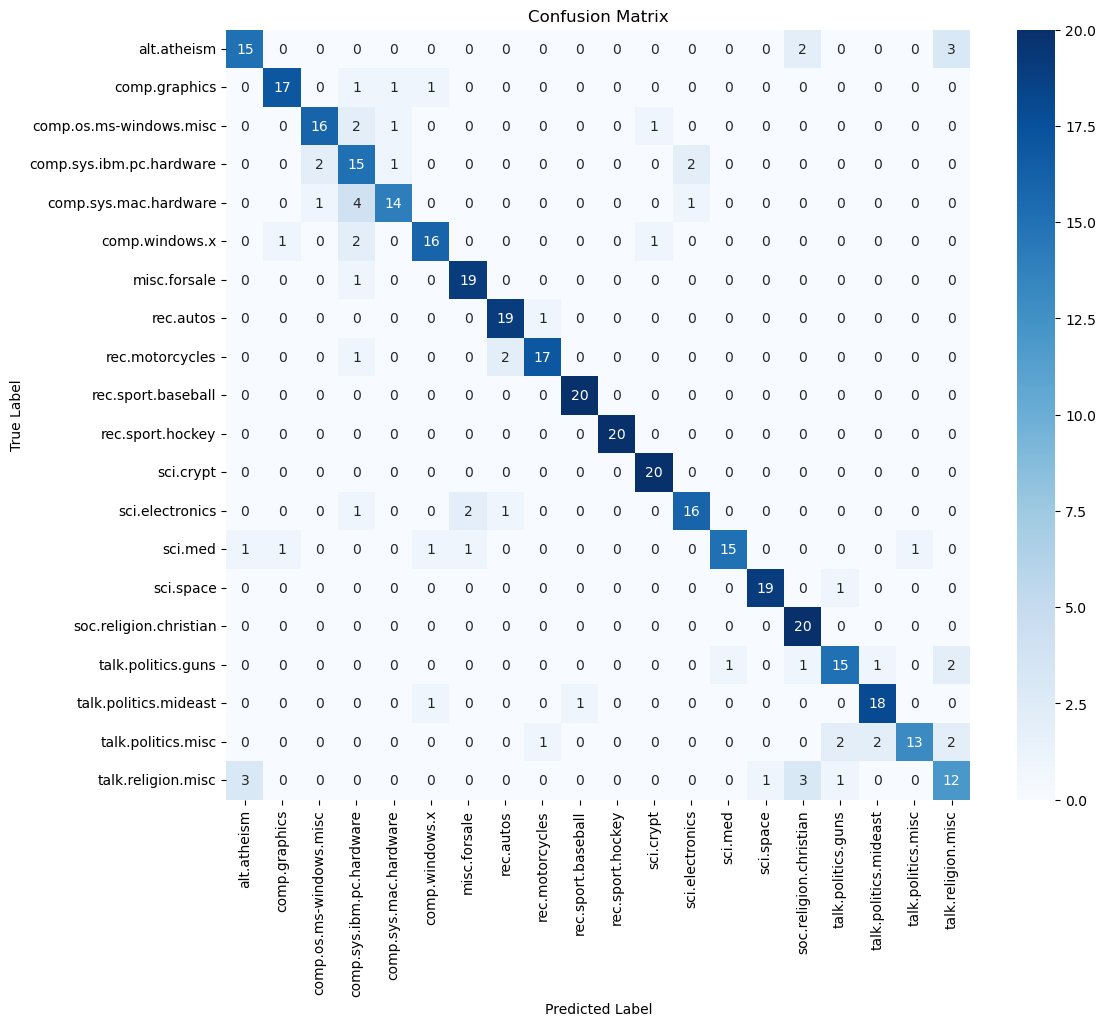

In [5]:
# Split Data, Train Model, and Predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Classification report
print("Classification Report")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

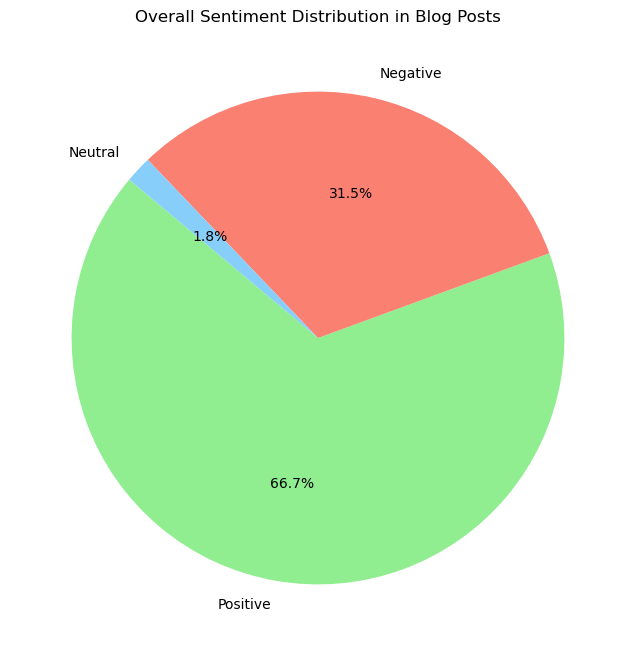

In [6]:
# Sentiment Analysis
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Sentiment Analysis and Pie Chart
df['Sentiment'] = df['Text'].apply(get_sentiment)
sentiment_counts = df['Sentiment'].value_counts()
colors = {'Positive': 'lightgreen', 'Neutral': 'lightskyblue', 'Negative': 'salmon'}

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts,
        labels=sentiment_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=[colors[key] for key in sentiment_counts.index])
plt.title('Overall Sentiment Distribution in Blog Posts')
plt.ylabel('') # Hide the default y-axis label
plt.show()

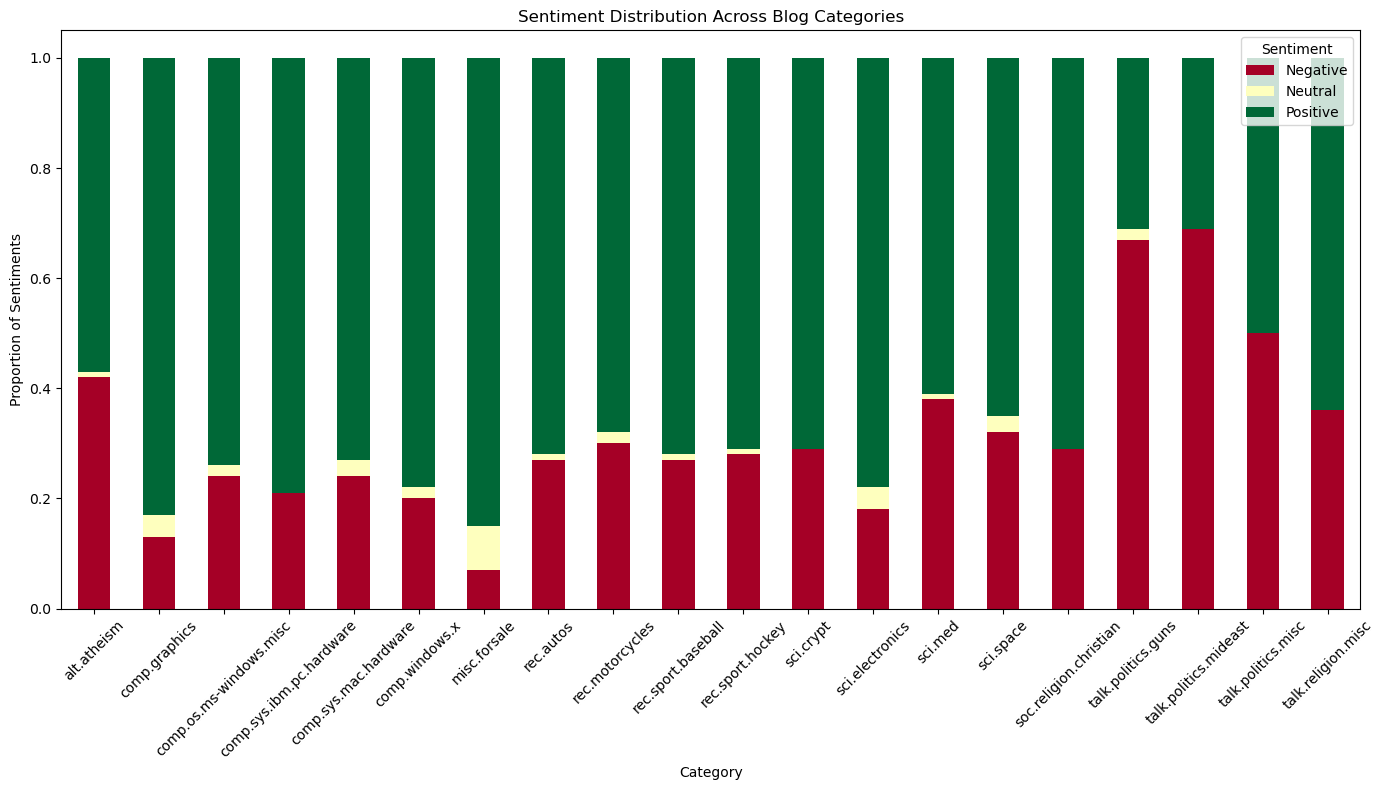

In [7]:
# Group Sentiments by Category and Visualize
sentiment_by_category = df.groupby('Category')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)

sentiment_by_category.plot(kind='bar', stacked=True, figsize=(14, 8),
                           colormap='RdYlGn', rot=45)
plt.title('Sentiment Distribution Across Blog Categories')
plt.xlabel('Category')
plt.ylabel('Proportion of Sentiments')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [8]:
def get_top_n_words(corpus, n=10):
    vec = TfidfVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return [word[0] for word in words_freq[:n]]

# Top words for each category
for category in df['Category'].unique():
    category_text = df[df['Category'] == category]['Clean_Text']
    top_words = get_top_n_words(category_text)
    print(f"Top 10 words for '{category}':")
    print(" | ".join(top_words))
    print("-" * 80)

Top 10 words for 'alt.atheism':
god | objective | people | writes | article | say | value | dont | atheist | think
--------------------------------------------------------------------------------
Top 10 words for 'comp.graphics':
file | line | compgraphics | path | subject | university | tiff | image | apr | organization
--------------------------------------------------------------------------------
Top 10 words for 'comp.os.ms-windows.misc':
window | file | nt | line | program | use | path | university | subject | newsgroups
--------------------------------------------------------------------------------
Top 10 words for 'comp.sys.ibm.pc.hardware':
drive | card | scsi | date | problem | line | work | disk | dx | apr
--------------------------------------------------------------------------------
Top 10 words for 'comp.sys.mac.hardware':
mac | monitor | line | card | apr | know | compsysmachardware | drive | subject | scsi
--------------------------------------------------------------

This markdown cell provides a template for your final report. Remember to replace "[Your Accuracy Score Here]" with the accuracy from the classification report in Cell 5.

**The Naive Bayes model achieved an overall accuracy of 84%.**

High-Performing Categories: The model excelled at identifying specific topics, achieving perfect scores for rec.sport.hockey and showing high precision/recall for categories like sci.crypt and rec.sport.baseball.

Areas for Improvement: It struggled with broader or overlapping categories, such as talk.religion.misc (**62% F1-score**) and comp.sys.ibm.pc.hardware (**64% F1-score**), where vocabulary was less distinct.

Sentiment Analysis Insights
Sentiment analysis revealed that the emotional tone of posts varies significantly by category.

**Overall: Most blogs have a Positive tone.**

**By Category**: Technical topics (comp.*, sci.*) were more Neutral, while recreational posts (rec.*) were largely Positive. Debate-heavy topics (talk.politics.*, alt.atheism) showed a greater mix of Negative and Neutral sentiments.

**Conclusion**
This assignment successfully classified blog posts using a **Naive Bayes** model with **84% accuracy** and analyzed their emotional tone. The results show that while the classifier is effective, its performance varies based on topic specificity. Sentiment analysis confirmed that content tone is closely linked to its category, providing a deeper understanding of the dataset.